<h3> Projekt 1<br>
Widzenie komputerowe<br>
Jakub Kondys, 151839<br>
Kacper Dąbrowski, 151521 </h3>

## Importy

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import display
import PIL
from typing import List, Any
from numpy.typing import NDArray

## Funkcje pomocnicze oraz wczytanie obrazów

In [4]:
def load_images(path, read_mode=cv2.IMREAD_COLOR):
    images, result = [], None
    for f in os.listdir(path):
        if f.endswith('.jpg') or f.endswith('.png'):
            full_path = path + "/" + f
            img_rgb = cv2.imread(full_path, read_mode)
        else:
            continue
        if f[:6] == 'result':
            result = img_rgb
        else:
            images.append(img_rgb)
    images = np.asarray(images)
    return images, result

def show_image(image):
    if image.shape[-1] == 1 or len(image.shape) < 4:
        #grayscale
        display(PIL.Image.fromarray(image))
    else:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        display(PIL.Image.fromarray(image_rgb))

def show_images(images):
    for img in images:
        show_image(img)

def convertion(img_list, cvt_type, idx):
    if cvt_type == "None":
        return img_list
    cvt_binary = [cv2.COLOR_BGR2GRAY, cv2.COLOR_RGB2GRAY, cv2.COLOR_RGBA2GRAY, cv2.COLOR_BGRA2GRAY]
    if cvt_type in cvt_binary:
        return [cv2.cvtColor(img, cvt_type) for img in img_list]
    return [cv2.cvtColor(img, cvt_type)[:,:,idx] for img in img_list]

def union(img_list: List[NDArray], threshold = 0, convert = "None", idx = 0):
    images = convertion(img_list, convert, idx)
    min_array = np.min(images, axis=0)
    max_array = np.max(images, axis=0)
    return np.array((max_array - min_array <= threshold), dtype=np.uint8)*255

In [5]:
images, result = load_images("cathedral")
images_grayscale = np.asarray([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images])
images_r, images_g, images_b = images[:,:,:,2], images[:,:,:,1], images[:,:,:,0]
images_hsv = np.asarray([cv2.cvtColor(image, cv2.COLOR_BGR2HSV) for image in images])
images_h, images_s, images_v = images_hsv[:,:,:,0], images_hsv[:,:,:,1], images_hsv[:,:,:,2]


images = images_hsv

## Analiza problemu
Zadanie dotyczy złożenia 5 zdjęć katedry tak, aby oczyścić je z ludzi:

<center><div>
<img src="cathedral/result.png" width="500"/>
</div></center>

Wszystkie obrazy są tej samej wielkości oraz są odpowiednio wykadrowane, więc w rezultacie wszystkie zdjęcia różnią się jedynie ruchami osób.

<center><div>
<img src="cathedral/d001.jpg" width="300"/>
<img src="cathedral/d002.jpg" width="300"/>
<img src="cathedral/d003.jpg" width="300"/>
<img src="cathedral/d004.jpg" width="300"/>
<img src="cathedral/d005.jpg" width="300"/>
</div></center>

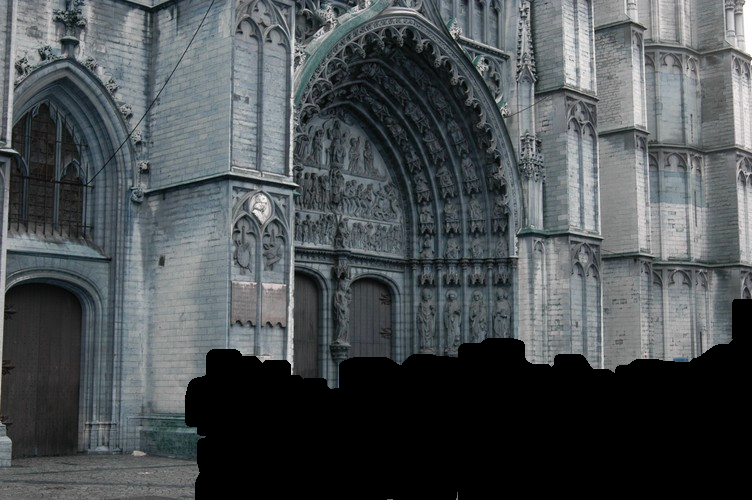

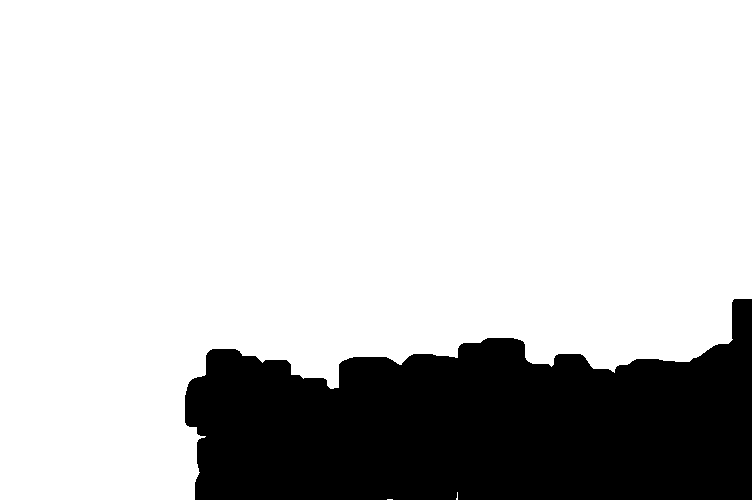

In [6]:
ker = 7
mask = np.bitwise_not(cv2.morphologyEx(cv2.medianBlur(cv2.morphologyEx(np.bitwise_not(union(images, threshold=15 ,convert=cv2.COLOR_BGR2GRAY, idx=2)), cv2.MORPH_OPEN, kernel=np.ones((ker,ker))),9), cv2.MORPH_DILATE, kernel=np.ones((20,20))))
final_img = np.zeros(images[0].shape, dtype=np.uint8)
final_img[:,:,0] = mask/255*images[0][:,:,0]
final_img[:,:,1] = mask/255*images[0][:,:,1]
final_img[:,:,2] = mask/255*images[0][:,:,2]
display(PIL.Image.fromarray(final_img))
show_image(mask)

In [7]:
def two_common_pixel(pixels, thresh = 0):
    for i in np.arange(len(pixels)):
        for j in np.arange(i, len(pixels)):
            if i == j:
                continue
            if np.abs(np.linalg.norm(pixels[i]) - np.linalg.norm(pixels[j])) <= thresh:
                return pixels[i]
    return np.array([0,0,0])

In [8]:
def find_same_area(img_list, start_img, thresh = 0):
    result = np.copy(start_img)
    mask = np.zeros((start_img.shape[0], start_img.shape[1]), dtype=np.uint8)
    for x in np.arange(start_img.shape[0]):
        for y in np.arange(start_img.shape[1]):
            if np.linalg.norm(result[x,y]) != 0:
                continue
            pixel_list = [img[x,y] for img in img_list]
            result[x,y] = two_common_pixel(pixel_list, thresh)
            if np.linalg.norm(result[x,y]) == 0:
                mask[x,y] = 255
    return result, mask

In [9]:
images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

In [10]:
cleaned_image, better_mask = find_same_area(images, final_img, thresh=1)

In [103]:
fast_copy = np.copy(cleaned_image)

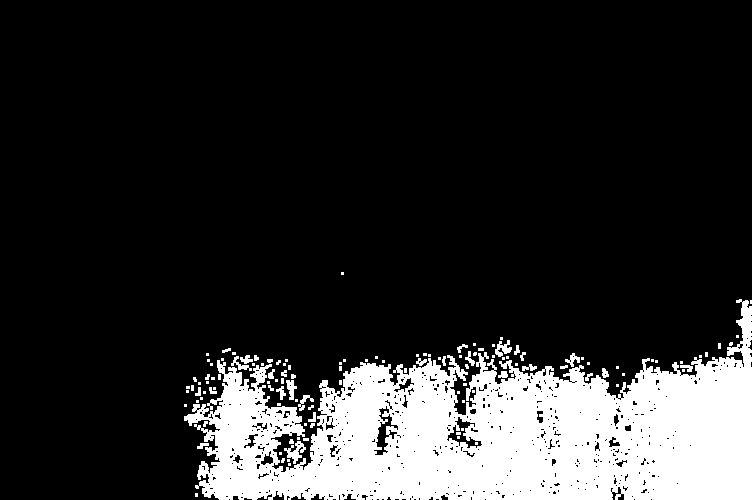

(500, 752)

In [11]:
best_mask = cv2.morphologyEx(better_mask, cv2.MORPH_DILATE, np.ones((3,3)))
show_image(best_mask)
best_mask.shape

In [12]:
cleaned_image = np.copy(fast_copy)

NameError: name 'fast_copy' is not defined

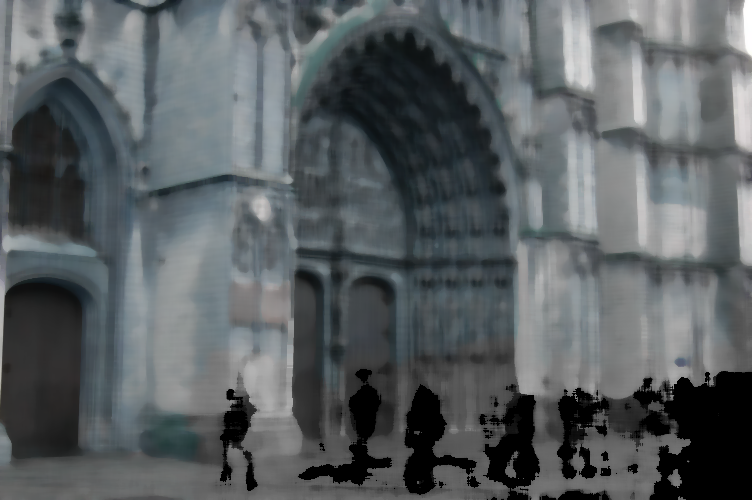

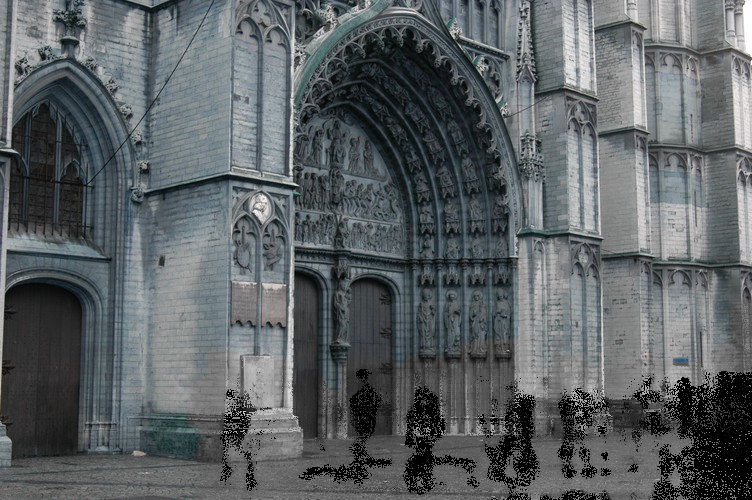

In [13]:
median = cv2.medianBlur(cleaned_image, 11)
show_image(median)
for i in range(3):
    cleaned_image[:,:,i] = cleaned_image[:,:,i]*(1-better_mask/255) + np.bitwise_and(median[:,:,i],better_mask)
show_image(cleaned_image)

In [14]:
cleaned_image_2, better_mask_2 = find_same_area(images, cleaned_image, thresh=2)

In [109]:
fast_copy = np.copy(cleaned_image_2)

In [15]:
cleaned_image_2 = np.copy(fast_copy)

NameError: name 'fast_copy' is not defined

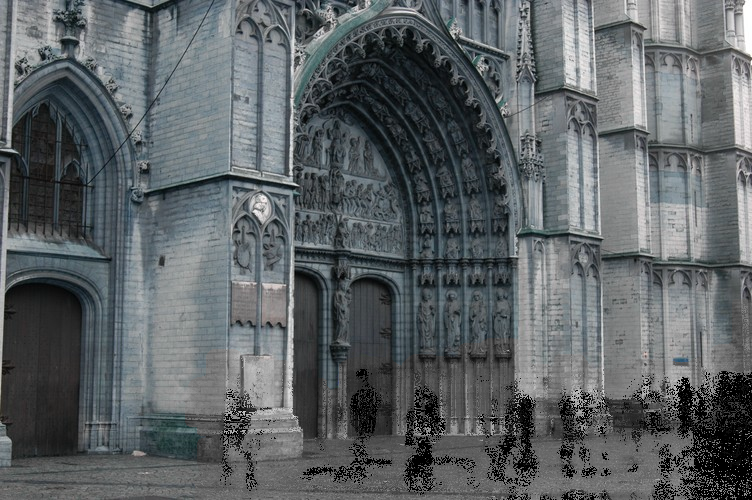

In [16]:
show_image(cleaned_image_2)

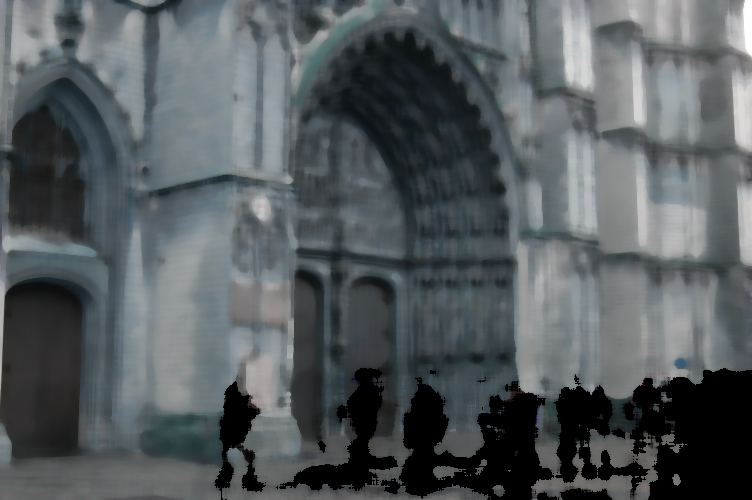

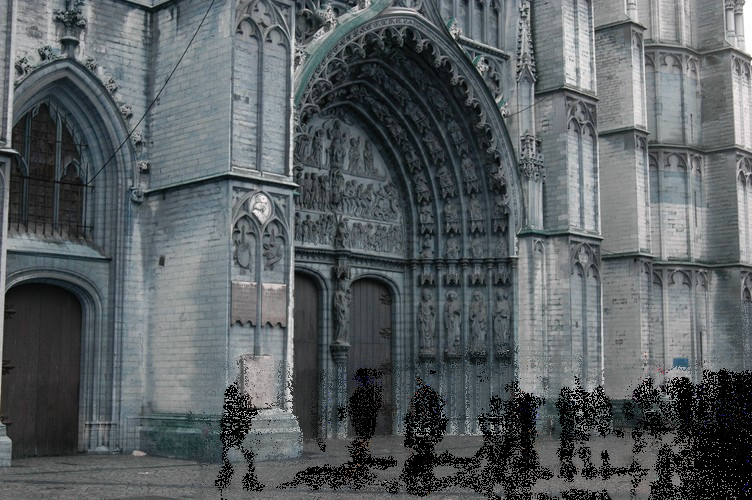

In [144]:
median = cv2.medianBlur(cleaned_image_2, 11)
show_image(median)
for i in range(3):
    cleaned_image_2[:,:,i] = cleaned_image_2[:,:,i]*(1-better_mask_2/255) + np.bitwise_and(median[:,:,i],better_mask_2)
show_image(cleaned_image_2)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 255,   0,   0]], shape=(500, 752), dtype=uint8)

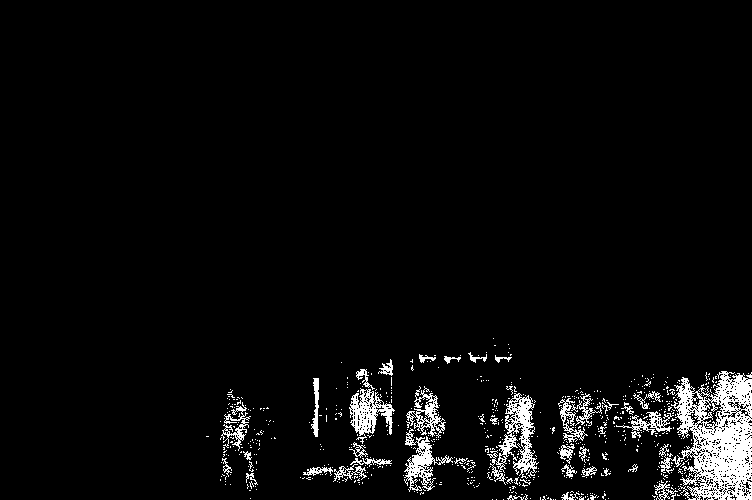

In [17]:
hsv_img = cv2.cvtColor(cleaned_image_2, cv2.COLOR_BGR2HSV)
final_mask = np.bitwise_and(np.array(hsv_img[:,:,2]<40, dtype=np.uint8)*255, 255-mask)
show_image(final_mask)

In [18]:
def image_average(img, mask, kernel = 3, iter = 1):
    pad = kernel-2
    result_img = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT)
    for _ in np.arange(iter):
        img = np.copy(result_img[pad:-pad,pad:-pad])
        for x in np.arange(img.shape[0]):
            for y in np.arange(img.shape[1]):
                if mask[x,y] == 0:
                    continue
                for i in range(img.shape[2]):
                    result_img[x+1,y+1,i] = np.sum(img[x-pad:x+pad,y-pad:y+pad,i])//np.count_nonzero(img[x-pad:x+pad,y-pad:y+pad,i])
    return result_img[pad:-pad, pad:-pad]

/tmp/ipykernel_511010/1020701817.py:11: RuntimeWarning: divide by zero encountered in scalar floor_divide
  result_img[x+1,y+1,i] = np.sum(img[x-pad:x+pad,y-pad:y+pad,i])//np.count_nonzero(img[x-pad:x+pad,y-pad:y+pad,i])


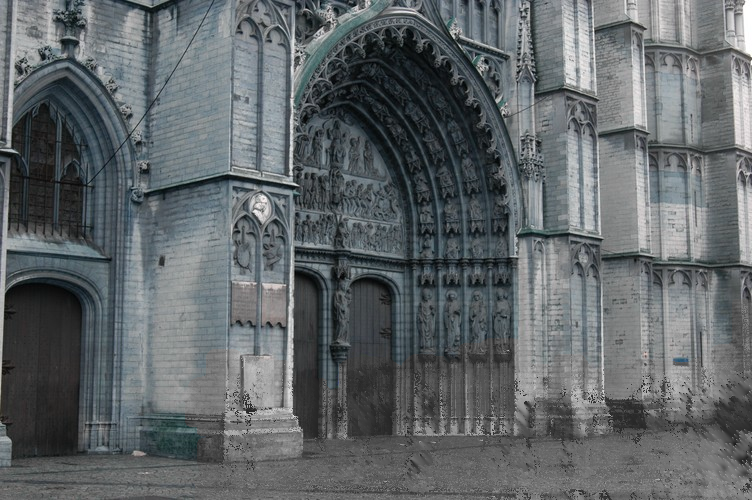

In [19]:
clear_image = image_average(cleaned_image_2, final_mask, kernel=3, iter=20)
show_image(clear_image)

In [ ]:
def find_people_diff(images, threshold = 20, how_many_for_valid = 3):
    where_people = []

    for x, image in enumerate(images):
        pixel_diffs = []
        for y, img in enumerate(images):
            if x == y:
                continue
            diff = cv2.absdiff(image, img)
            pixel_diffs.append(diff)

        # for each pixel, count number of diffs where difference in pixel values > threshold
        pixel_diffs = np.asarray(pixel_diffs)
        pixel_diffs_above_threshold = (pixel_diffs > threshold).astype(np.uint8)
        img_count_above_threshold = pixel_diffs_above_threshold.sum(axis=0)

        where_ppl = (img_count_above_threshold >= how_many_for_valid) * 255
        where_people.append(where_ppl)

    where_people = np.asarray(where_people, dtype=np.uint8)

    return where_people
    

In [ ]:
# CHAT

def find_cathedral_windowed(images, threshold=20, window_size=3):
    # Średnia ze wszystkich obrazów
    mean_image = np.mean(images, axis=0)

    # Absolutna różnica względem średniej
    diff_images = np.abs(images - mean_image)
    summed_diff = np.sum(diff_images, axis=0)  # shape: (H, W, C)

    # Zamieniamy na obraz w skali szarości (lub sumujemy kanały)
    if len(summed_diff.shape) == 3:
        summed_diff_gray = np.sum(summed_diff, axis=2)  # shape: (H, W)
    else:
        summed_diff_gray = summed_diff

    # Przesuwające się okno – suma różnic w 3x3
    kernel = np.ones((window_size, window_size), dtype=np.float32)
    local_sum = cv2.filter2D(summed_diff_gray, -1, kernel, borderType=cv2.BORDER_REFLECT) // len(images) # TODO? - chyba git

    # Progowanie: gdzie różnice są mniejsze niż próg → potencjalna katedra
    where_cathedral = local_sum <= threshold

    return where_cathedral


In [7]:
def find_cathedral(images, threshold = 20, how_many_for_valid = 5):
    where_cathedral = None

    min_images = np.min(images, axis=0)
    max_images = np.max(images, axis=0)
    # diff_images = max_images - min_images
    mean_images = np.mean(images, axis=0)
    diff_images = np.sum(np.abs(images - mean_images), axis=0)
    where_cathedral = (diff_images <= threshold)
    
    return where_cathedral

In [8]:
def Q_task(img_bin, struct):
  c = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, struct)
  oc = cv2.morphologyEx(c, cv2.MORPH_OPEN, struct)
  coc = cv2.morphologyEx(oc, cv2.MORPH_CLOSE, struct)
  res = np.minimum(img_bin, coc)
  return res

def A(img_bin, struct):
  o = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, struct)
  co = cv2.morphologyEx(o, cv2.MORPH_CLOSE, struct)
  oco = cv2.morphologyEx(co, cv2.MORPH_OPEN, struct)
  q = Q_task(img_bin, struct)
  res = np.maximum(oco, q)
  return res

In [ ]:
# CHAT
def find_best_shift(img1, img2, max_shift=10, threshold = 10):
    """
    Znajduje przesunięcie (dx, dy), które najlepiej dopasowuje img1 do img2,
    ignorując zawinięte piksele.
    """
    h, w = img1.shape
    best_score = float('inf')
    best_shift = (0, 0)

    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            # Wyznacz wspólny obszar (crop)
            x1_start = max(0, dx)
            x1_end   = w + min(0, dx)
            y1_start = max(0, dy)
            y1_end   = h + min(0, dy)

            x2_start = max(0, -dx)
            x2_end   = w - max(0, dx)
            y2_start = max(0, -dy)
            y2_end   = h - max(0, dy)

            # Wyciągamy wspólne fragmenty
            region1 = img1[y1_start:y1_end, x1_start:x1_end]
            region2 = img2[y2_start:y2_end, x2_start:x2_end]

            # Porównujemy różnicę
            score = np.sum(np.abs(region1 - region2) > threshold)  # lub np.square(...)

            if score < best_score:
                best_score = score
                best_shift = (dx, dy)

    return best_shift


Shift for image 1: (0, 0)
Shift for image 2: (0, 0)
Shift for image 3: (0, 0)
321301


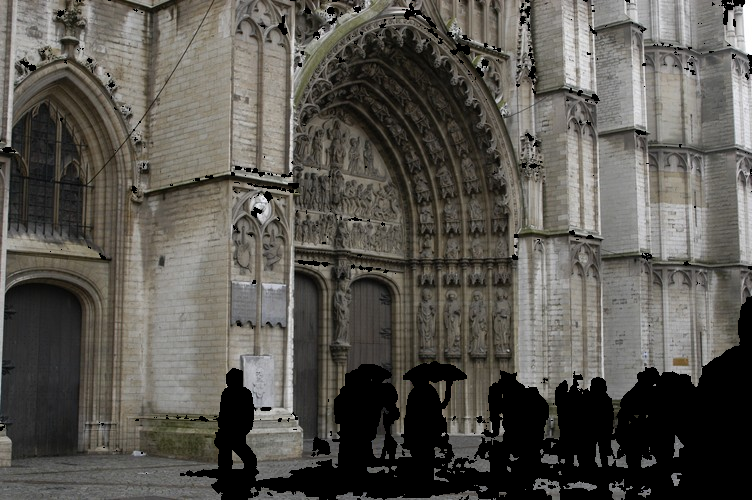

54699
(54699, 3) (54699, 3) (500, 752)
(54699, 3) (54699, 3) (500, 752)
(54699, 3) (54699, 3) (500, 752)
(54699, 3) (54699, 3) (500, 752)
(54699, 3) (54699, 3) (500, 752)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
images_test = images_grayscale.copy()
images_test = images_test[:4,:,:]
for i, img in enumerate(images_test[1:]):
    best_shift = find_best_shift(img, images_test[0], max_shift=5, threshold=5)
    images_test[i+1] = np.roll(img, best_shift, axis=(0, 1))
    print(f"Shift for image {i+1}: {best_shift}")

images_test = np.asarray([cv2.medianBlur(image, 3) for image in images_test])
final_image = np.zeros_like(images_grayscale[0])
final_bgr = np.zeros_like(images[0])
finished = np.zeros_like(images_grayscale[0])
# for i, img in enumerate(images_test[:-2]):
#     where_cathedral = []
#     for j, img2 in enumerate(images_test[i+1:]):
#         wc = find_cathedral_windowed([img, img2], threshold = 150, window_size=5)
#         where_cathedral.append(wc)
#     where_cathedral = np.sum(where_cathedral, axis=0) > len(images_test) - 3 - i
#     final_image[(where_cathedral > 0) & (finished == 0)] = 255
#     final_bgr[(where_cathedral > 0) & (finished == 0)] = images[i][(where_cathedral > 0) & (finished == 0)]
#     print(np.sum(where_cathedral[(finished == 0)]))
#     finished[(where_cathedral > 0) & (finished == 0)] = 1

# porównuj obraz 0 z pozostałymi i zwracaj dla każdego piksela wektor True/False czy suma różnic pikseli w oknie 5x5 poniżej threshold (w grayscale)
where_cathedral = []
img = images_test[0]
for j, img2 in enumerate(images_test[1:]):
    wc = find_cathedral_windowed([img, img2], threshold = 50, window_size=5)
    where_cathedral.append(wc)

# jak dla co najmniej 2 obrazów z 3 suma jest mniejsza to znaczy że obrazy są podobne w tych miejscach - jako ostateczny obraz w tych miejscach przypisz obraz 0 w BGR
where_cathedral = np.sum(where_cathedral, axis=0) > len(images_test) - 3
final_image[(where_cathedral > 0) & (finished == 0)] = 255
final_bgr[(where_cathedral > 0) & (finished == 0)] = images[0][(where_cathedral > 0) & (finished == 0)]
print(np.sum(where_cathedral[(finished == 0)]))
finished[(where_cathedral > 0) & (finished == 0)] = 1
final_rgb = cv2.cvtColor(final_bgr, cv2.COLOR_BGR2RGB)
show_image(final_rgb, "cathedral")


# 1. wypełnij w iteracji nieskończone piksele wartościami najbliższych skończonych pilseli
# 2. jeśli minimalna różnica między ostatecznym obrazem a obrazem składowym jest mniejsza niż z przypisz piksel z obrazu składowego wBGR
# zwiększaj z co iterację
from scipy.ndimage import distance_transform_edt # TODO: zamieńić

z = 0 
while np.sum(finished == 0) > 0:
    print(np.sum(finished == 0))
    
    mask = (finished == 0)  # piksele, które trzeba uzupełnić

    # Odległość + pozycje najbliższych punktów gdzie finished == 1
    # distance_transform_edt zwraca też indeksy do najbliższego punktu ≠ 0
    dist, (y_indices, x_indices) = distance_transform_edt(mask, return_indices=True) # TODO: zastąpić własną funkcją - wyliczanie dystansów euklidesowych i indeksów punktów które są najbliższe

    # Dla wszystkich "dziur" – kopiujemy wartości BGR z najbliższych gotowych punktów
    filled_final_bgr = final_bgr.copy()
    filled_final_bgr[mask] = final_bgr[y_indices[mask], x_indices[mask]]
    diffs = []
    for i, img in enumerate(images[:5]):
        diff = np.sum(cv2.absdiff(filled_final_bgr, img), axis=2) # TODO? no niby funkcja prosta ale nie było na zajęciach
        diffs.append(diff)
    args_min_diff = np.argmin(diffs, axis=0)

    Y, X = final_bgr.shape[:2]

    # jeśli pixel nie finished i minimalny diff jest mnijeszy niż próg z to wpisz pixel z obrazu z min diff
    for y in range(Y):
        for x in range(X):
            if finished[y, x] == 0 and diffs[args_min_diff[y, x]][y, x] < z:
                src_img_idx = args_min_diff[y, x]
                final_bgr[y, x] = images[src_img_idx][y, x]
                finished[y, x] = 1

    z += ((z//10) ** 2 + 1)
    print(z)
    
final_rgb = cv2.cvtColor(final_bgr, cv2.COLOR_BGR2RGB)

show_image(final_rgb, "final_image")


In [16]:
# final_bgr = cv2.medianBlur(final_bgr, 3)
# final_rgb = cv2.cvtColor(final_bgr, cv2.COLOR_BGR2RGB)

# show_image(final_rgb, "final_image")

In [12]:
import numpy as np
import cv2
from collections import Counter

def quantize_to_top5_colors(images, topC = 20):
    output_images = []

    for img in images:
        # reshape: (H, W, 3) -> (H*W, 3)
        pixels = img.reshape(-1, 3)
        
        # Konwersja do tuple (bo Counter nie lubi list)
        pixels_tuple = [tuple(p) for p in pixels]
        most_common = Counter(pixels_tuple).most_common(topC)
        top_colors = np.array([color for color, _ in most_common], dtype=np.uint8)  # shape: (5, 3)

        # Obliczamy odległość każdego piksela do 5 kolorów
        dists = np.linalg.norm(pixels[:, None] - top_colors[None, :], axis=2)  # shape: (N_pixels, 5)
        nearest_color_indices = np.argmin(dists, axis=1)

        # Zamieniamy każdy piksel na najbliższy top5 kolor
        new_pixels = top_colors[nearest_color_indices]  # shape: (N_pixels, 3)
        new_image = new_pixels.reshape(img.shape)
        output_images.append(new_image)

    return np.array(output_images)


In [13]:
# quantized_images = quantize_to_top5_colors(images, 20)
# print(quantized_images.shape)

# rgb = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in quantized_images]
# show_images(rgb)


In [15]:
# where_people = find_people_diff(images_r, threshold=20, how_many_for_valid=4)
# dilated = open(close(where_people))
# show_images(dilated)